In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 100

In [4]:
TRAIN_INPUT_DIR = "data/trainA"  # Poor-quality images
TRAIN_TARGET_DIR = "data/trainB"  # Enhanced images

In [5]:
image_filenames = sorted(os.listdir(TRAIN_INPUT_DIR))

In [6]:
train_files, val_files = train_test_split(image_filenames, test_size=0.2, random_state=42)


In [7]:
class ImageDataGenerator(Sequence):
    def __init__(self, input_dir, target_dir, file_list, batch_size=16, img_size=(256, 256)):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_filenames = file_list

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.image_filenames[index * self.batch_size: (index + 1) * self.batch_size]
        input_images, target_images = [], []

        for filename in batch_files:
            input_path = os.path.join(self.input_dir, filename)
            target_path = os.path.join(self.target_dir, filename)

            if os.path.exists(target_path):  # Ensure paired images exist
                input_images.append(self.load_image(input_path))
                target_images.append(self.load_image(target_path))

        return np.array(input_images), np.array(target_images)

    def load_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0  # Normalize
        return img

In [8]:
train_generator = ImageDataGenerator(TRAIN_INPUT_DIR, TRAIN_TARGET_DIR, train_files, batch_size=BATCH_SIZE)
val_generator = ImageDataGenerator(TRAIN_INPUT_DIR, TRAIN_TARGET_DIR, val_files, batch_size=BATCH_SIZE)

In [9]:
x_batch, y_batch = train_generator[0]
print(f"Loaded batch shape: {x_batch.shape}, {y_batch.shape}")

Loaded batch shape: (16, 256, 256, 3), (16, 256, 256, 3)


In [10]:
def build_cnn(img_shape=(256, 256, 3)):
    inputs = Input(img_shape)

    # Encoder (Downsampling)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(inputs)  # 256 → 128
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)  # 128 → 64
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding="same")(x)  # 64 → 32
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Decoder (Upsampling)
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same")(x)  # 32 → 64
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)  # 64 → 128
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same")(x)  # 128 → 256
    x = BatchNormalization()(x)
    x = ReLU()(x)

    output = Conv2D(3, kernel_size=3, strides=1, padding="same", activation="sigmoid")(x)  # Final output 256x256x3

    model = Model(inputs, output)
    return model

In [11]:
model = build_cnn()
model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse', metrics=['mae'])

In [12]:
history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/277 ━━━━━━━━━━━━━━━━━━━━ 50s 133ms/step - loss: 0.0380 - mae: 0.1442 - val_loss: 0.0430 - val_mae: 0.1719
Epoch 2/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.0158 - mae: 0.0895 - val_loss: 0.0170 - val_mae: 0.0970
Epoch 3/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - loss: 0.0145 - mae: 0.0855 - val_loss: 0.0135 - val_mae: 0.0806
Epoch 4/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - loss: 0.0133 - mae: 0.0812 - val_loss: 0.0135 - val_mae: 0.0833
Epoch 5/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - loss: 0.0128 - mae: 0.0794 - val_loss: 0.0142 - val_mae: 0.0803
Epoch 6/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 0.0127 - mae: 0.0788 - val_loss: 0.0119 - val_mae: 0.0735
Epoch 7/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 0.0124 - mae: 0.0771 - val_loss: 0.0116 - val_mae: 0.0735
Epoch 8/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - loss: 0.0123 - mae: 0.0772 - val_loss: 0.0115 - val_mae: 0.0730
Epoch 9/100
277/277 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


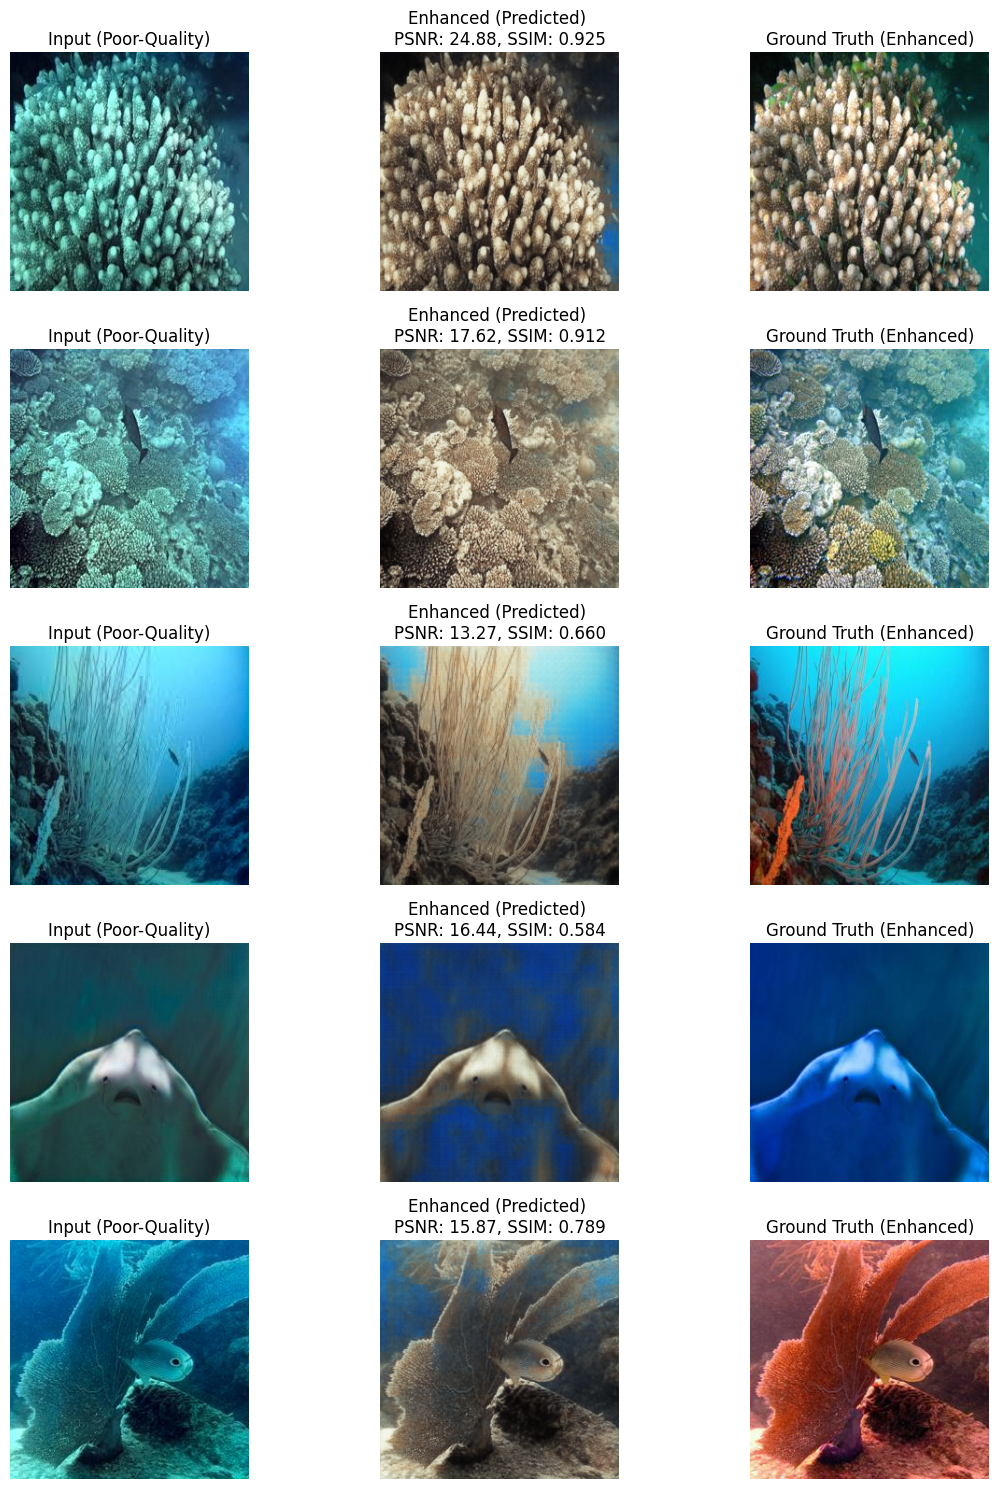

Average MSE: 0.0232
Average PSNR: 17.62 dB
Average SSIM: 0.774
Average MAE: 0.1041


In [14]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import cv2

# ==============================
# EVALUATION METRICS
# ==============================
def calculate_mse(imageA, imageB):
    """Compute Mean Squared Error (MSE)"""
    return np.mean((imageA - imageB) ** 2)

def calculate_psnr(imageA, imageB):
    """Compute Peak Signal-to-Noise Ratio (PSNR)"""
    mse = calculate_mse(imageA, imageB)
    if mse == 0:
        return 100  # If identical, return a high PSNR
    PIXEL_MAX = 1.0  # Since images are normalized [0,1]
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img1, img2):
    """Calculate SSIM between two images."""
    return ssim(img1, img2, data_range=1.0, channel_axis=-1, win_size=5)  # Set win_size to avoid error


def calculate_mae(imageA, imageB):
    """Compute Mean Absolute Error (MAE)"""
    return np.mean(np.abs(imageA - imageB))

# ==============================
# MODEL PREDICTIONS & METRICS
# ==============================
def evaluate_model(model, generator, num_samples=5):
    """Evaluates the model on a few samples and computes metrics"""
    sample_indices = np.random.choice(len(generator), num_samples, replace=False)

    mse_scores, psnr_scores, ssim_scores, mae_scores = [], [], [], []

    plt.figure(figsize=(12, num_samples * 3))

    for i, idx in enumerate(sample_indices):
        input_batch, target_batch = generator[idx]  # Get a batch
        predicted_batch = model.predict(input_batch)  # Get model predictions

        # Take the first sample from the batch
        input_img = input_batch[0]
        target_img = target_batch[0]
        predicted_img = predicted_batch[0]

        # Compute Metrics
        mse = calculate_mse(target_img, predicted_img)
        psnr = calculate_psnr(target_img, predicted_img)
        ssim_val = calculate_ssim(target_img, predicted_img)
        mae = calculate_mae(target_img, predicted_img)

        mse_scores.append(mse)
        psnr_scores.append(psnr)
        ssim_scores.append(ssim_val)
        mae_scores.append(mae)

        # Plot input, predicted, and target
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(input_img)
        plt.axis("off")
        plt.title("Input (Poor-Quality)")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(predicted_img)
        plt.axis("off")
        plt.title(f"Enhanced (Predicted) \nPSNR: {psnr:.2f}, SSIM: {ssim_val:.3f}")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(target_img)
        plt.axis("off")
        plt.title("Ground Truth (Enhanced)")

    plt.tight_layout()
    plt.show()

    # Print Average Metrics
    print(f"Average MSE: {np.mean(mse_scores):.4f}")
    print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")
    print(f"Average SSIM: {np.mean(ssim_scores):.3f}")
    print(f"Average MAE: {np.mean(mae_scores):.4f}")

# ==============================
# RUN EVALUATION
# ==============================
evaluate_model(model, val_generator, num_samples=5)


In [15]:
model.save("enhanced_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


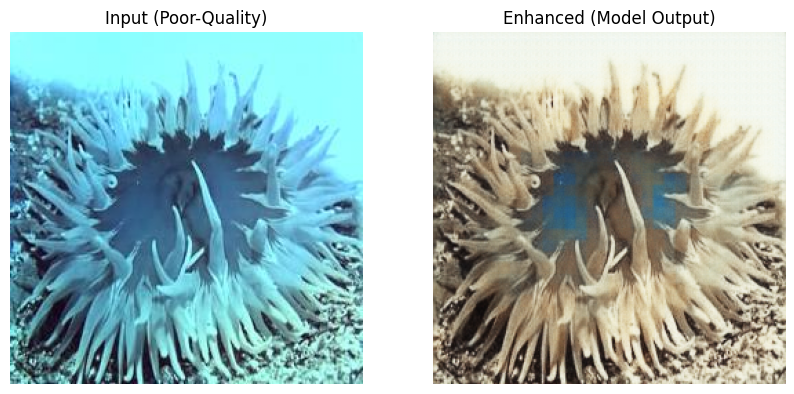

Enhanced image saved at: enhanced_image.jpg


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def enhance_image(model, image_path):
    """Loads an image, enhances it using the model, and displays the result."""

    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (256, 256))  # Resize to model's input shape
    img = img / 255.0  # Normalize to [0,1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Generate enhanced image
    enhanced_img = model.predict(img)[0]  # Remove batch dimension
    enhanced_img = np.clip(enhanced_img, 0, 1)  # Ensure valid pixel range

    # Display results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.axis("off")
    plt.title("Input (Poor-Quality)")

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_img)
    plt.axis("off")
    plt.title("Enhanced (Model Output)")

    plt.show()

    # Save enhanced image
    enhanced_img = (enhanced_img * 255).astype(np.uint8)  # Convert back to 0-255 range
    output_path = "enhanced_image.jpg"
    cv2.imwrite(output_path, cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for saving

    print(f"Enhanced image saved at: {output_path}")

# Example usage
image_path = "265944_n01914609_3606.JPEG"  # Change this to your image
enhance_image(model, image_path)
